In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam

import seaborn as sns
import random
import csv

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler


In [2]:
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection
from tensorflow.keras.layers import LSTM

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from matplotlib import pyplot as plt

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, PReLU
from keras_tuner.tuners import RandomSearch

from sklearn.metrics import mean_absolute_percentage_error

Using TensorFlow backend


In [4]:
df=pd.read_csv('icecream_sales_date 2009-2022.csv', index_col='date', parse_dates=True,encoding="utf-8")
df.head()

,sales,tokyo_temperature,holiday,Unnamed: 4,temperature_difference_2009_2018,temperature_difference_2019_2021,Unnamed: 7,2009,2010,2011,...,2015,2016,2017,2018,2019,2020,2021,2022,AVERAGE2009-2018,AVERAGE2019-2021
date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,17.59,10.6,1,NaN,0.521429,0.033333,1.0,10.2,11.0,9.1,...,10.4,10.6,10.8,9.4,10.3,11.1,10.3,9.4,10.078571,10.566667
2009-01-02,23.83,11.6,1,NaN,1.521429,1.033333,2.0,11.5,9.9,11.2,...,10.4,12.2,12.1,10.1,11.6,13.3,14.0,10.5,11.142857,12.966667
2009-01-03,22.94,10.7,1,NaN,0.621429,0.133333,3.0,13.7,13.2,12.3,...,15.5,14.9,13.4,16.9,15.4,16.0,17.9,16.6,14.942857,16.433333
2009-01-04,17.14,11.1,1,NaN,1.021429,0.533333,4.0,20.2,16.6,18.9,...,19.3,20.3,19.9,22.1,19.0,18.2,20.6,20.2,19.471429,19.266667
2009-01-05,10.32,11.8,0,NaN,1.721429,1.233333,5.0,23.6,23.0,22.2,...,26.4,25.2,25.1,24.6,25.3,24.0,24.1,23.5,24.242857,24.466667


In [5]:
#df_train=df["2009-01-01":"2018-12-31"]
#df_test=df["2019-01-01":"2019-12-31"]
df_19=df["2009-01-01":"2019-12-31"]

In [6]:
sales=df_19["sales"]
sales

date
2009-01-01    17.59
2009-01-02    23.83
2009-01-03    22.94
2009-01-04    17.14
2009-01-05    10.32
              ...  
2019-12-27    18.54
2019-12-28    24.99
2019-12-29    33.16
2019-12-30    25.73
2019-12-31    33.84
Name: sales, Length: 4015, dtype: float64

In [7]:
sales_train=sales["2009-01-01":"2018-12-31"]
sales_test=sales["2019-01-01":"2019-12-31"]

In [8]:
sales_np = np.array(sales, dtype=float)
sales_np

array([17.59, 23.83, 22.94, ..., 33.16, 25.73, 33.84])

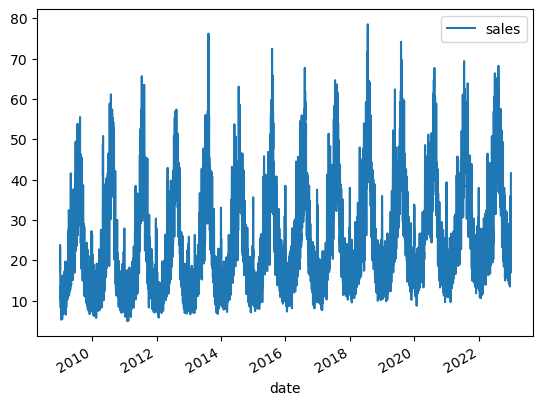

In [9]:
saless=df["sales"]
saless.plot()
#ヨコ軸のラベル
plt.legend()                                       #凡例表示
plt.show()

In [10]:
series=sales_np
series.shape

(4015,)

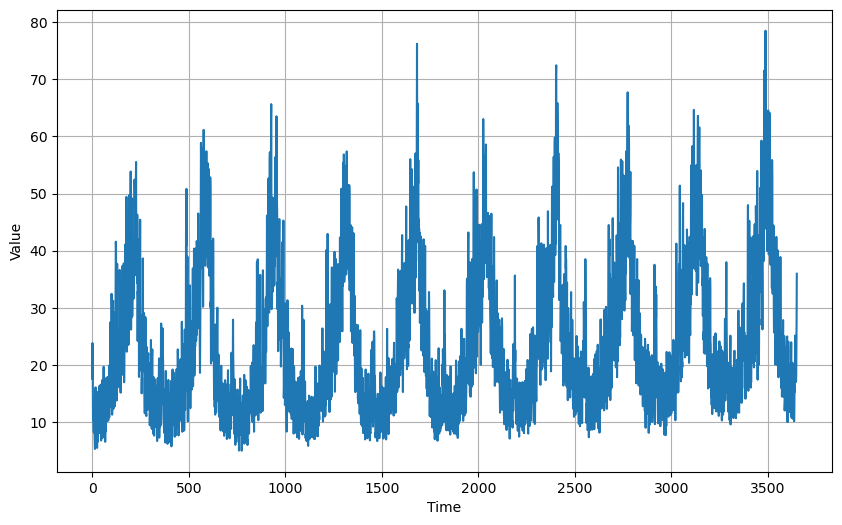

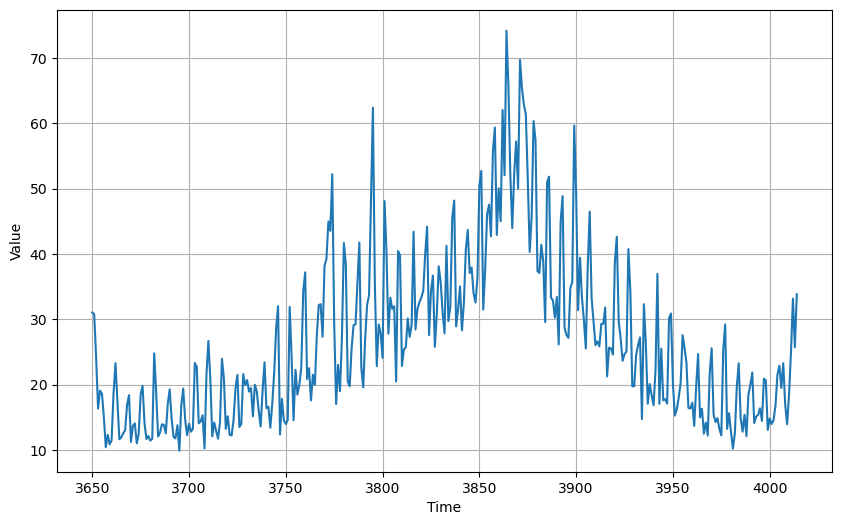

In [11]:
year=10
split_time = 365*year
time = np.arange(365*year+365, dtype="float32")

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


window_size = 32
batch_size = 256
shuffle_buffer_size = 4000

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train) # 学習セット
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid) # 検証セット
plt.show()

In [12]:
def windowing(df, window_size):
  x = []
  y = []

  for i in range(len(df) - window_size):
    x_result = df[i:i+window_size].to_list()
    x.append(x_result)
    y_result = df[i+window_size]
    y.append(y_result)

  return np.array(x), np.array(y)

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [14]:
x_train

array([17.59, 23.83, 22.94, ..., 22.93, 27.97, 35.97])

In [15]:
sales

date
2009-01-01    17.59
2009-01-02    23.83
2009-01-03    22.94
2009-01-04    17.14
2009-01-05    10.32
              ...  
2019-12-27    18.54
2019-12-28    24.99
2019-12-29    33.16
2019-12-30    25.73
2019-12-31    33.84
Name: sales, Length: 4015, dtype: float64

In [16]:
window_size = 20

x_train_lstm, y_train_lstm = windowing(sales_train, window_size)
x_test_lstm, y_test_lstm = windowing(sales_test,window_size)

In [17]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# build lstm model
lstm_model = Sequential()
lstm_model.add(LSTM(100, input_shape=(window_size, 1)))
lstm_model.add(Dense(10))
lstm_model.add(Dense(1))
#lstm_model.add(LSTM(100, input_shape=[window_size, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.5))
#lstm_model.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.5, activation='relu')) 
#lstm_model.add(Dense(1))
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 41,821
Trainable params: 41,821
Non-trainable params: 0
_________________________________________________________________


In [18]:
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, 
        verbose=1, mode='auto', restore_best_weights=True)

In [19]:
cp = ModelCheckpoint('model/', save_best_only=True)
lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())

In [20]:
# train lstm model
history = lstm_model.fit(x_train_lstm, y_train_lstm, validation_data=(x_test_lstm, y_test_lstm), epochs=50, batch_size=32, callbacks=[cp])

Epoch 1/50
111/114 [============================>.] - ETA: 0s - loss: 604.7294 - root_mean_squared_error: 24.5912

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 8s 51ms/step - loss: 603.7549 - root_mean_squared_error: 24.5714 - val_loss: 715.3688 - val_root_mean_squared_error: 26.7464
Epoch 2/50
114/114 [==============================] - ETA: 0s - loss: 423.7312 - root_mean_squared_error: 20.5847

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 45ms/step - loss: 423.7312 - root_mean_squared_error: 20.5847 - val_loss: 474.3055 - val_root_mean_squared_error: 21.7786
Epoch 3/50
111/114 [============================>.] - ETA: 0s - loss: 258.9337 - root_mean_squared_error: 16.0914

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 45ms/step - loss: 257.2962 - root_mean_squared_error: 16.0405 - val_loss: 284.9007 - val_root_mean_squared_error: 16.8790
Epoch 4/50
114/114 [==============================] - ETA: 0s - loss: 173.3065 - root_mean_squared_error: 13.1646

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 43ms/step - loss: 173.3065 - root_mean_squared_error: 13.1646 - val_loss: 208.7380 - val_root_mean_squared_error: 14.4478
Epoch 5/50
111/114 [============================>.] - ETA: 0s - loss: 130.2138 - root_mean_squared_error: 11.4111

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 44ms/step - loss: 130.4709 - root_mean_squared_error: 11.4224 - val_loss: 160.7641 - val_root_mean_squared_error: 12.6793
Epoch 6/50
111/114 [============================>.] - ETA: 0s - loss: 99.6835 - root_mean_squared_error: 9.9842  

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 47ms/step - loss: 100.3170 - root_mean_squared_error: 10.0158 - val_loss: 125.7777 - val_root_mean_squared_error: 11.2151
Epoch 7/50
114/114 [==============================] - ETA: 0s - loss: 82.2084 - root_mean_squared_error: 9.0669

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 42ms/step - loss: 82.2084 - root_mean_squared_error: 9.0669 - val_loss: 104.1985 - val_root_mean_squared_error: 10.2078
Epoch 8/50
111/114 [============================>.] - ETA: 0s - loss: 70.2482 - root_mean_squared_error: 8.3814

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 47ms/step - loss: 70.9155 - root_mean_squared_error: 8.4211 - val_loss: 91.9063 - val_root_mean_squared_error: 9.5868
Epoch 9/50
112/114 [============================>.] - ETA: 0s - loss: 63.1966 - root_mean_squared_error: 7.9496

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 44ms/step - loss: 63.0270 - root_mean_squared_error: 7.9390 - val_loss: 81.2388 - val_root_mean_squared_error: 9.0133
Epoch 10/50
110/114 [===========================>..] - ETA: 0s - loss: 57.0875 - root_mean_squared_error: 7.5556

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 45ms/step - loss: 56.9209 - root_mean_squared_error: 7.5446 - val_loss: 74.6865 - val_root_mean_squared_error: 8.6421
Epoch 11/50
112/114 [============================>.] - ETA: 0s - loss: 52.5422 - root_mean_squared_error: 7.2486

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 46ms/step - loss: 52.2951 - root_mean_squared_error: 7.2315 - val_loss: 70.4943 - val_root_mean_squared_error: 8.3961
Epoch 12/50
113/114 [============================>.] - ETA: 0s - loss: 49.0262 - root_mean_squared_error: 7.0019

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 48ms/step - loss: 49.1471 - root_mean_squared_error: 7.0105 - val_loss: 65.3975 - val_root_mean_squared_error: 8.0869
Epoch 13/50
110/114 [===========================>..] - ETA: 0s - loss: 47.1128 - root_mean_squared_error: 6.8639

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 42ms/step - loss: 46.8228 - root_mean_squared_error: 6.8427 - val_loss: 62.3122 - val_root_mean_squared_error: 7.8938
Epoch 14/50
110/114 [===========================>..] - ETA: 0s - loss: 44.0388 - root_mean_squared_error: 6.6362

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 48ms/step - loss: 44.3036 - root_mean_squared_error: 6.6561 - val_loss: 58.9089 - val_root_mean_squared_error: 7.6752
Epoch 15/50
111/114 [============================>.] - ETA: 0s - loss: 42.3242 - root_mean_squared_error: 6.5057

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 44ms/step - loss: 42.7977 - root_mean_squared_error: 6.5420 - val_loss: 56.8388 - val_root_mean_squared_error: 7.5392
Epoch 16/50
111/114 [============================>.] - ETA: 0s - loss: 41.6770 - root_mean_squared_error: 6.4558

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 45ms/step - loss: 41.5646 - root_mean_squared_error: 6.4471 - val_loss: 54.4113 - val_root_mean_squared_error: 7.3764
Epoch 17/50
114/114 [==============================] - ETA: 0s - loss: 39.9002 - root_mean_squared_error: 6.3167

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 45ms/step - loss: 39.9002 - root_mean_squared_error: 6.3167 - val_loss: 53.0061 - val_root_mean_squared_error: 7.2805
Epoch 18/50
114/114 [==============================] - ETA: 0s - loss: 38.8131 - root_mean_squared_error: 6.2300

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 48ms/step - loss: 38.8131 - root_mean_squared_error: 6.2300 - val_loss: 50.7701 - val_root_mean_squared_error: 7.1253
Epoch 19/50
114/114 [==============================] - 1s 11ms/step - loss: 37.9076 - root_mean_squared_error: 6.1569 - val_loss: 51.3137 - val_root_mean_squared_error: 7.1634
Epoch 20/50
111/114 [============================>.] - ETA: 0s - loss: 37.6261 - root_mean_squared_error: 6.1340

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 43ms/step - loss: 37.5633 - root_mean_squared_error: 6.1289 - val_loss: 48.7516 - val_root_mean_squared_error: 6.9822
Epoch 21/50
110/114 [===========================>..] - ETA: 0s - loss: 36.6913 - root_mean_squared_error: 6.0573

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 45ms/step - loss: 36.7550 - root_mean_squared_error: 6.0626 - val_loss: 47.6221 - val_root_mean_squared_error: 6.9009
Epoch 22/50
111/114 [============================>.] - ETA: 0s - loss: 35.4842 - root_mean_squared_error: 5.9569

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 50ms/step - loss: 35.8275 - root_mean_squared_error: 5.9856 - val_loss: 46.2947 - val_root_mean_squared_error: 6.8040
Epoch 23/50
111/114 [============================>.] - ETA: 0s - loss: 34.6467 - root_mean_squared_error: 5.8861

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 45ms/step - loss: 34.7366 - root_mean_squared_error: 5.8938 - val_loss: 45.0729 - val_root_mean_squared_error: 6.7136
Epoch 24/50
111/114 [============================>.] - ETA: 0s - loss: 34.2045 - root_mean_squared_error: 5.8485

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 46ms/step - loss: 34.0528 - root_mean_squared_error: 5.8355 - val_loss: 44.3194 - val_root_mean_squared_error: 6.6573
Epoch 25/50
112/114 [============================>.] - ETA: 0s - loss: 33.6170 - root_mean_squared_error: 5.7980

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 46ms/step - loss: 33.6865 - root_mean_squared_error: 5.8040 - val_loss: 43.8257 - val_root_mean_squared_error: 6.6201
Epoch 26/50
114/114 [==============================] - 1s 11ms/step - loss: 33.3447 - root_mean_squared_error: 5.7745 - val_loss: 43.8570 - val_root_mean_squared_error: 6.6225
Epoch 27/50
111/114 [============================>.] - ETA: 0s - loss: 33.1985 - root_mean_squared_error: 5.7618

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 46ms/step - loss: 32.9949 - root_mean_squared_error: 5.7441 - val_loss: 41.8438 - val_root_mean_squared_error: 6.4687
Epoch 28/50
110/114 [===========================>..] - ETA: 0s - loss: 32.5639 - root_mean_squared_error: 5.7065

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 45ms/step - loss: 32.4373 - root_mean_squared_error: 5.6954 - val_loss: 41.8169 - val_root_mean_squared_error: 6.4666
Epoch 29/50
110/114 [===========================>..] - ETA: 0s - loss: 32.8247 - root_mean_squared_error: 5.7293

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 47ms/step - loss: 32.7563 - root_mean_squared_error: 5.7233 - val_loss: 41.1544 - val_root_mean_squared_error: 6.4152
Epoch 30/50
112/114 [============================>.] - ETA: 0s - loss: 31.8844 - root_mean_squared_error: 5.6466

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 42ms/step - loss: 31.7854 - root_mean_squared_error: 5.6379 - val_loss: 40.1251 - val_root_mean_squared_error: 6.3344
Epoch 31/50
111/114 [============================>.] - ETA: 0s - loss: 31.5278 - root_mean_squared_error: 5.6150

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 49ms/step - loss: 31.3994 - root_mean_squared_error: 5.6035 - val_loss: 39.9351 - val_root_mean_squared_error: 6.3194
Epoch 32/50
114/114 [==============================] - 2s 14ms/step - loss: 31.2866 - root_mean_squared_error: 5.5934 - val_loss: 40.4933 - val_root_mean_squared_error: 6.3634
Epoch 33/50
110/114 [===========================>..] - ETA: 0s - loss: 31.5825 - root_mean_squared_error: 5.6198

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 45ms/step - loss: 31.3312 - root_mean_squared_error: 5.5974 - val_loss: 39.0152 - val_root_mean_squared_error: 6.2462
Epoch 34/50
112/114 [============================>.] - ETA: 0s - loss: 31.0484 - root_mean_squared_error: 5.5721

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 48ms/step - loss: 31.0223 - root_mean_squared_error: 5.5698 - val_loss: 38.9182 - val_root_mean_squared_error: 6.2384
Epoch 35/50
114/114 [==============================] - 2s 14ms/step - loss: 30.6230 - root_mean_squared_error: 5.5338 - val_loss: 39.1267 - val_root_mean_squared_error: 6.2551
Epoch 36/50
113/114 [============================>.] - ETA: 0s - loss: 30.4773 - root_mean_squared_error: 5.5206

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 45ms/step - loss: 30.5510 - root_mean_squared_error: 5.5273 - val_loss: 38.4008 - val_root_mean_squared_error: 6.1968
Epoch 37/50
112/114 [============================>.] - ETA: 0s - loss: 29.9760 - root_mean_squared_error: 5.4750

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 46ms/step - loss: 30.0211 - root_mean_squared_error: 5.4792 - val_loss: 38.3417 - val_root_mean_squared_error: 6.1921
Epoch 38/50
114/114 [==============================] - 2s 13ms/step - loss: 30.3220 - root_mean_squared_error: 5.5065 - val_loss: 38.4615 - val_root_mean_squared_error: 6.2017
Epoch 39/50
113/114 [============================>.] - ETA: 0s - loss: 30.0094 - root_mean_squared_error: 5.4781

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 45ms/step - loss: 29.9986 - root_mean_squared_error: 5.4771 - val_loss: 37.8896 - val_root_mean_squared_error: 6.1555
Epoch 40/50
111/114 [============================>.] - ETA: 0s - loss: 29.6697 - root_mean_squared_error: 5.4470

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 49ms/step - loss: 29.5665 - root_mean_squared_error: 5.4375 - val_loss: 36.7388 - val_root_mean_squared_error: 6.0613
Epoch 41/50
114/114 [==============================] - 1s 12ms/step - loss: 29.3905 - root_mean_squared_error: 5.4213 - val_loss: 37.1155 - val_root_mean_squared_error: 6.0922
Epoch 42/50
114/114 [==============================] - 1s 11ms/step - loss: 29.2900 - root_mean_squared_error: 5.4120 - val_loss: 36.9695 - val_root_mean_squared_error: 6.0803
Epoch 43/50
110/114 [===========================>..] - ETA: 0s - loss: 28.9567 - root_mean_squared_error: 5.3811

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 46ms/step - loss: 28.9254 - root_mean_squared_error: 5.3782 - val_loss: 36.2524 - val_root_mean_squared_error: 6.0210
Epoch 44/50
111/114 [============================>.] - ETA: 0s - loss: 28.9641 - root_mean_squared_error: 5.3818

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 47ms/step - loss: 29.0418 - root_mean_squared_error: 5.3890 - val_loss: 35.6268 - val_root_mean_squared_error: 5.9688
Epoch 45/50
110/114 [===========================>..] - ETA: 0s - loss: 28.7543 - root_mean_squared_error: 5.3623

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 49ms/step - loss: 28.6605 - root_mean_squared_error: 5.3536 - val_loss: 35.2394 - val_root_mean_squared_error: 5.9363
Epoch 46/50
111/114 [============================>.] - ETA: 0s - loss: 28.2840 - root_mean_squared_error: 5.3183

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 43ms/step - loss: 28.5287 - root_mean_squared_error: 5.3412 - val_loss: 35.1521 - val_root_mean_squared_error: 5.9289
Epoch 47/50
114/114 [==============================] - 1s 13ms/step - loss: 28.6703 - root_mean_squared_error: 5.3545 - val_loss: 36.7162 - val_root_mean_squared_error: 6.0594
Epoch 48/50
112/114 [============================>.] - ETA: 0s - loss: 29.0142 - root_mean_squared_error: 5.3865

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 5s 48ms/step - loss: 28.8707 - root_mean_squared_error: 5.3731 - val_loss: 34.3205 - val_root_mean_squared_error: 5.8584
Epoch 49/50
114/114 [==============================] - 2s 14ms/step - loss: 28.0959 - root_mean_squared_error: 5.3006 - val_loss: 35.8725 - val_root_mean_squared_error: 5.9894
Epoch 50/50
114/114 [==============================] - 1s 12ms/step - loss: 27.9471 - root_mean_squared_error: 5.2865 - val_loss: 36.6174 - val_root_mean_squared_error: 6.0512


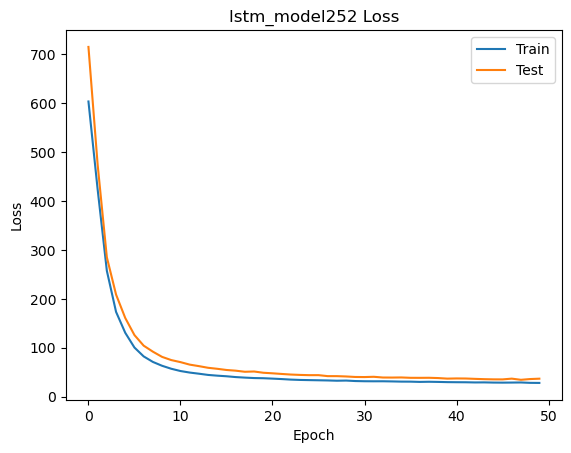

In [21]:
# plot train and test loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('lstm_model252 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [22]:
loss_df = pd.DataFrame({'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss = pd.DataFrame({'min': loss_df.min(), 'max': loss_df.max()})
loss
print(loss_df.min())

loss        27.947100
val_loss    34.320522
dtype: float64


In [23]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [24]:
forecast = model_forecast(lstm_model, series[split_time - window_size:-1], window_size)[:,0]

12/12 [==============================] - 2s 121ms/step


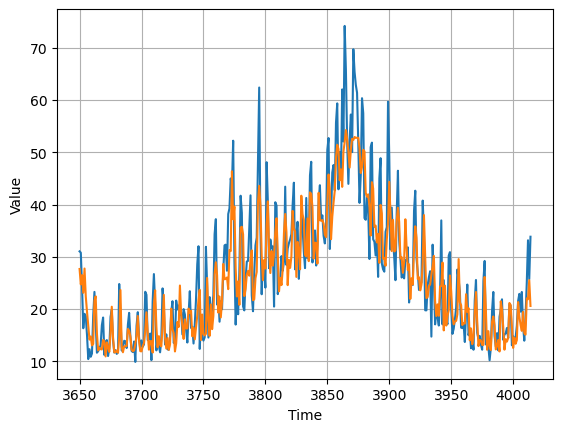

In [25]:
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [26]:
print('RMSE : ',np.sqrt(((x_valid - forecast)**2).mean()))

RMSE :  5.971326548922406
